In [2]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adamax
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow as tf
%matplotlib inline
import numpy as np
import cv2
from skimage.util import random_noise

# Step 1: Process the data

In [3]:
#Declaring constants
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=32 # The images will be resized to 28x28 pixels

In [4]:
data_dir=os.path.join('..','input/numta')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

## Image processing
We shall write some helper functions to process and visualize the images. We will convert color to gray scale image. For better understanding we will unblur the image and make image sharp by using laplacian filter.

In [64]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):
    '''reads images from the filepaths, resizes them (if given), and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: pass image label filepaths while processing training data, defaults to None while processing testing data
        resize_dim: if given, the image is resized to resize_dim x resize_dim (optional)
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # images loaded in color (BGR)
        #img = cv2.bilateralFilter(img,9,75,75)
        #img = cv2.medianBlur(img,5)
        #img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
        #img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # cnahging colorspace to GRAY
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
        #X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv2.filter2D(img, -1, kernel)
        #thresh = 200
        #maxValue = 255
        #th, img = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY);
        ret,img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y
        
def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: If the images are plotted after resizing, pass 'processed' to phase argument. 
            It will plot the image and its true label. If the image is plotted after prediction 
            phase, pass predicted class probabilities to y_pred and 'prediction' to the phase argument. 
            It will plot the image, the true label, and it's top 3 predictions with highest probabilities.
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=int(np.ceil(n_sample/n_per_row))
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
#         img_sq=np.squeeze(img,axis=2)
#         plt.imshow(img_sq,cmap='gray')
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

Next we are going to use the `get_data()` function to process all the images from dataset

In [6]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [7]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 32, 32), (72045, 10))

In [8]:
X_show_all=X_train_all

Let's see some samples of the processed data. The digits are more sharp now

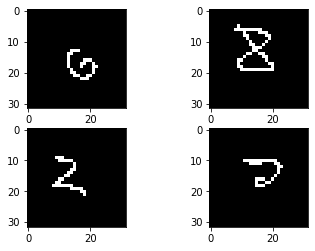

In [9]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [10]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [11]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [12]:
X_tshow_all=X_test_all
X_tshow_all.shape

(17626, 32, 32)

We will now convert image to 1 color channel

In [13]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],32, 32,1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],32, 32,1).astype('float32')

## Train image shape & sample

In [14]:
X_train_all.shape

(72045, 32, 32, 1)

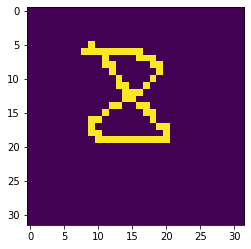

In [15]:
plt.imshow(X_train_all[1])

# Test image shape & sample

In [16]:
X_test_all.shape

(17626, 32, 32, 1)

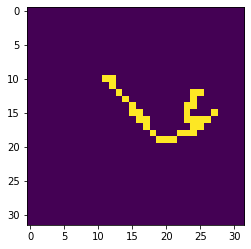

In [17]:
plt.imshow(X_test_all[1])

# Interpolating train images

In [18]:
m = 2

X_train_all_big = np.empty(shape=[72045, 32*m, 32*m, 1])
X_train_all_big.shape

(72045, 64, 64, 1)

In [19]:
for i in range(0, 72045):
    big_img = cv2.resize(X_train_all[i], None, fx=m, fy=m, interpolation=cv2.INTER_NEAREST)
    big_img = big_img[:, :, np.newaxis]
    X_train_all_big[i] = big_img
    if i==72044:
        end='\n'
    else: 
        end='\r'
    print('processed {}/72045'.format(i+1),end=end)

X_train_all_big.shape

processed 72045/72045


(72045, 64, 64, 1)

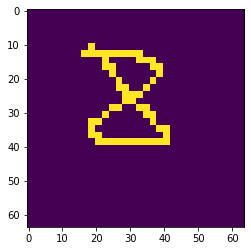

In [20]:
plt.imshow(X_train_all_big[1])

# Interpolating test images

In [21]:
X_test_all_big = np.empty(shape=[17626, 32*m, 32*m, 1])
X_test_all_big.shape

(17626, 64, 64, 1)

In [22]:
for i in range(0, 17626):
    big_img = cv2.resize(X_test_all[i], None, fx=m, fy=m, interpolation=cv2.INTER_NEAREST)
    big_img = big_img[:, :, np.newaxis]
    X_test_all_big[i] = big_img
    if i==17625:
        end='\n'
    else: 
        end='\r'
    print('processed {}/17626'.format(i+1),end=end)

X_test_all_big.shape

processed 17626/17626


(17626, 64, 64, 1)

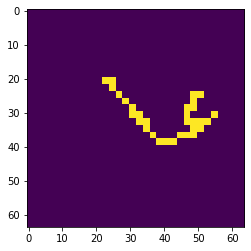

In [23]:
plt.imshow(X_test_all_big[1])

# Adding noise to train images

In [24]:
for i in range(0, 72045):
    X_train_all_big[i] = random_noise(X_train_all_big[i], mode='salt', seed=None, clip=True)
    if i==72044:
        end='\n'
    else: 
        end='\r'
    print('processed {}/72045'.format(i+1),end=end)

processed 72045/72045


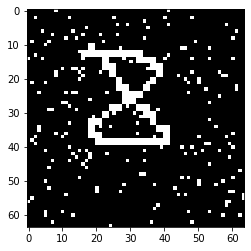

In [25]:
plt.imshow(X_train_all_big[1], cmap = "gray")

# Adding noise to test images

In [26]:
for i in range(0, 17626):
    X_test_all_big[i] = random_noise(X_test_all_big[i], mode='salt', seed=None, clip=True)
    if i==17625:
        end='\n'
    else: 
        end='\r'
    print('processed {}/17626'.format(i+1),end=end)

processed 17626/17626


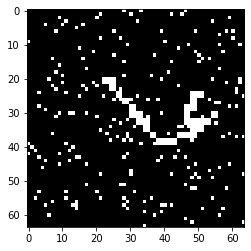

In [27]:
plt.imshow(X_test_all_big[1], cmap = "gray")

# Denoising train images

In [28]:
for i in range(0, 72045):
    denoised_img = cv2.medianBlur(X_train_all_big[i].astype('float32'), 3)
    X_train_all_big[i] = denoised_img[:, :, np.newaxis]
    if i==72044:
        end='\n'
    else: 
        end='\r'
    print('processed {}/72045'.format(i+1),end=end)

processed 72045/72045


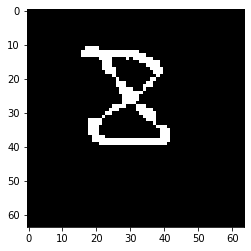

In [29]:
plt.imshow(X_train_all_big[1], cmap = "gray")

# Denoising test images

In [30]:
for i in range(0, 17626):
    denoised_img = cv2.medianBlur(X_test_all_big[i].astype('float32'), 3)
    X_test_all_big[i] = denoised_img[:, :, np.newaxis]
    if i < 17625:
        end='\r'
    else: 
        end='\n'
    print('processed {}/17626'.format(i+1),end=end)

processed 17626/17626


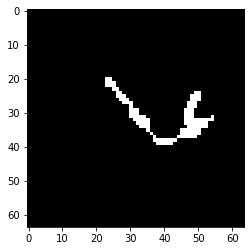

In [31]:
plt.imshow(X_test_all_big[1], cmap = "gray")

In [32]:
X_test_all_big[1].shape

(64, 64, 1)

## Normalize data

In [33]:
X_train_all = X_train_all/255
X_test_all = X_test_all/255

Next, we are going to randomly choose 80% of the training data and use it to train our neural network. The remaining 20% images are going to be our validation data.

In [34]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all_big[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all_big[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]

In [35]:
X_train.shape

(57636, 64, 64, 1)

# Step 2: Design the model

In [36]:
def my_model(img_size=64,channels=1):
    model = Sequential()
    input_shape = (img_size,img_size,channels)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model
model=my_model()
model.summary()

2022-09-25 18:47:56.342948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       147712    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 512)       1

2022-09-25 18:47:56.437676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 18:47:56.438457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 18:47:56.439817: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 18:47:56.440141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Step 3: Train the model

In [37]:
path_model='model_filter.h1' # save model at this location after each epoch
tf.compat.v1.keras.backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

2022-09-25 18:48:08.489597: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 944308224 exceeds 10% of free system memory.
2022-09-25 18:48:09.547361: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 944308224 exceeds 10% of free system memory.
2022-09-25 18:48:10.320146: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-25 18:48:11.834258: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


901/901 [==============================] - 58s 54ms/step - loss: 0.6077 - accuracy: 0.7909 - val_loss: 0.1695 - val_accuracy: 0.9482


2022-09-25 18:49:08.700415: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/20
901/901 [==============================] - 47s 52ms/step - loss: 0.1624 - accuracy: 0.9500 - val_loss: 0.1081 - val_accuracy: 0.9679
Epoch 3/20
901/901 [==============================] - 47s 52ms/step - loss: 0.1129 - accuracy: 0.9658 - val_loss: 0.1018 - val_accuracy: 0.9711
Epoch 4/20
901/901 [==============================] - 47s 52ms/step - loss: 0.0882 - accuracy: 0.9726 - val_loss: 0.1008 - val_accuracy: 0.9736
Epoch 5/20
901/901 [==============================] - 47s 52ms/step - loss: 0.0708 - accuracy: 0.9777 - val_loss: 0.1029 - val_accuracy: 0.9713
Epoch 6/20
901/901 [==============================] - 47s 52ms/step - loss: 0.0598 - accuracy: 0.9816 - val_loss: 0.1086 - val_accuracy: 0.9739
Epoch 7/20
901/901 [==============================] - 47s 52ms/step - loss: 0.0520 - accuracy: 0.9833 - val_loss: 0.1035 - val_accuracy: 0.9733
Epoch 8/20
901/901 [==============================] - 47s 52ms/step - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.1046 - val_accuracy:

## Result Analysis
Let's observe the images by our model

In [38]:
X_test_all.shape

(17626, 32, 32, 1)

In [39]:
predictions_prob=model.predict(X_test_all_big) # get predictions for all the test data

In [61]:
n_sample=200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all_big), size=n_sample)
len(X_test_all_big)

17626

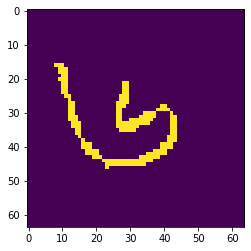

In [54]:
plt.imshow(X_test_all_big[0])

In [58]:
predictions_prob[0]

array([5.4094786e-29, 8.7075929e-31, 1.4045039e-21, 5.9906441e-08,
       1.2840827e-32, 1.1788655e-19, 9.9999988e-01, 2.6723578e-27,
       2.6345460e-13, 8.9226884e-25], dtype=float32)

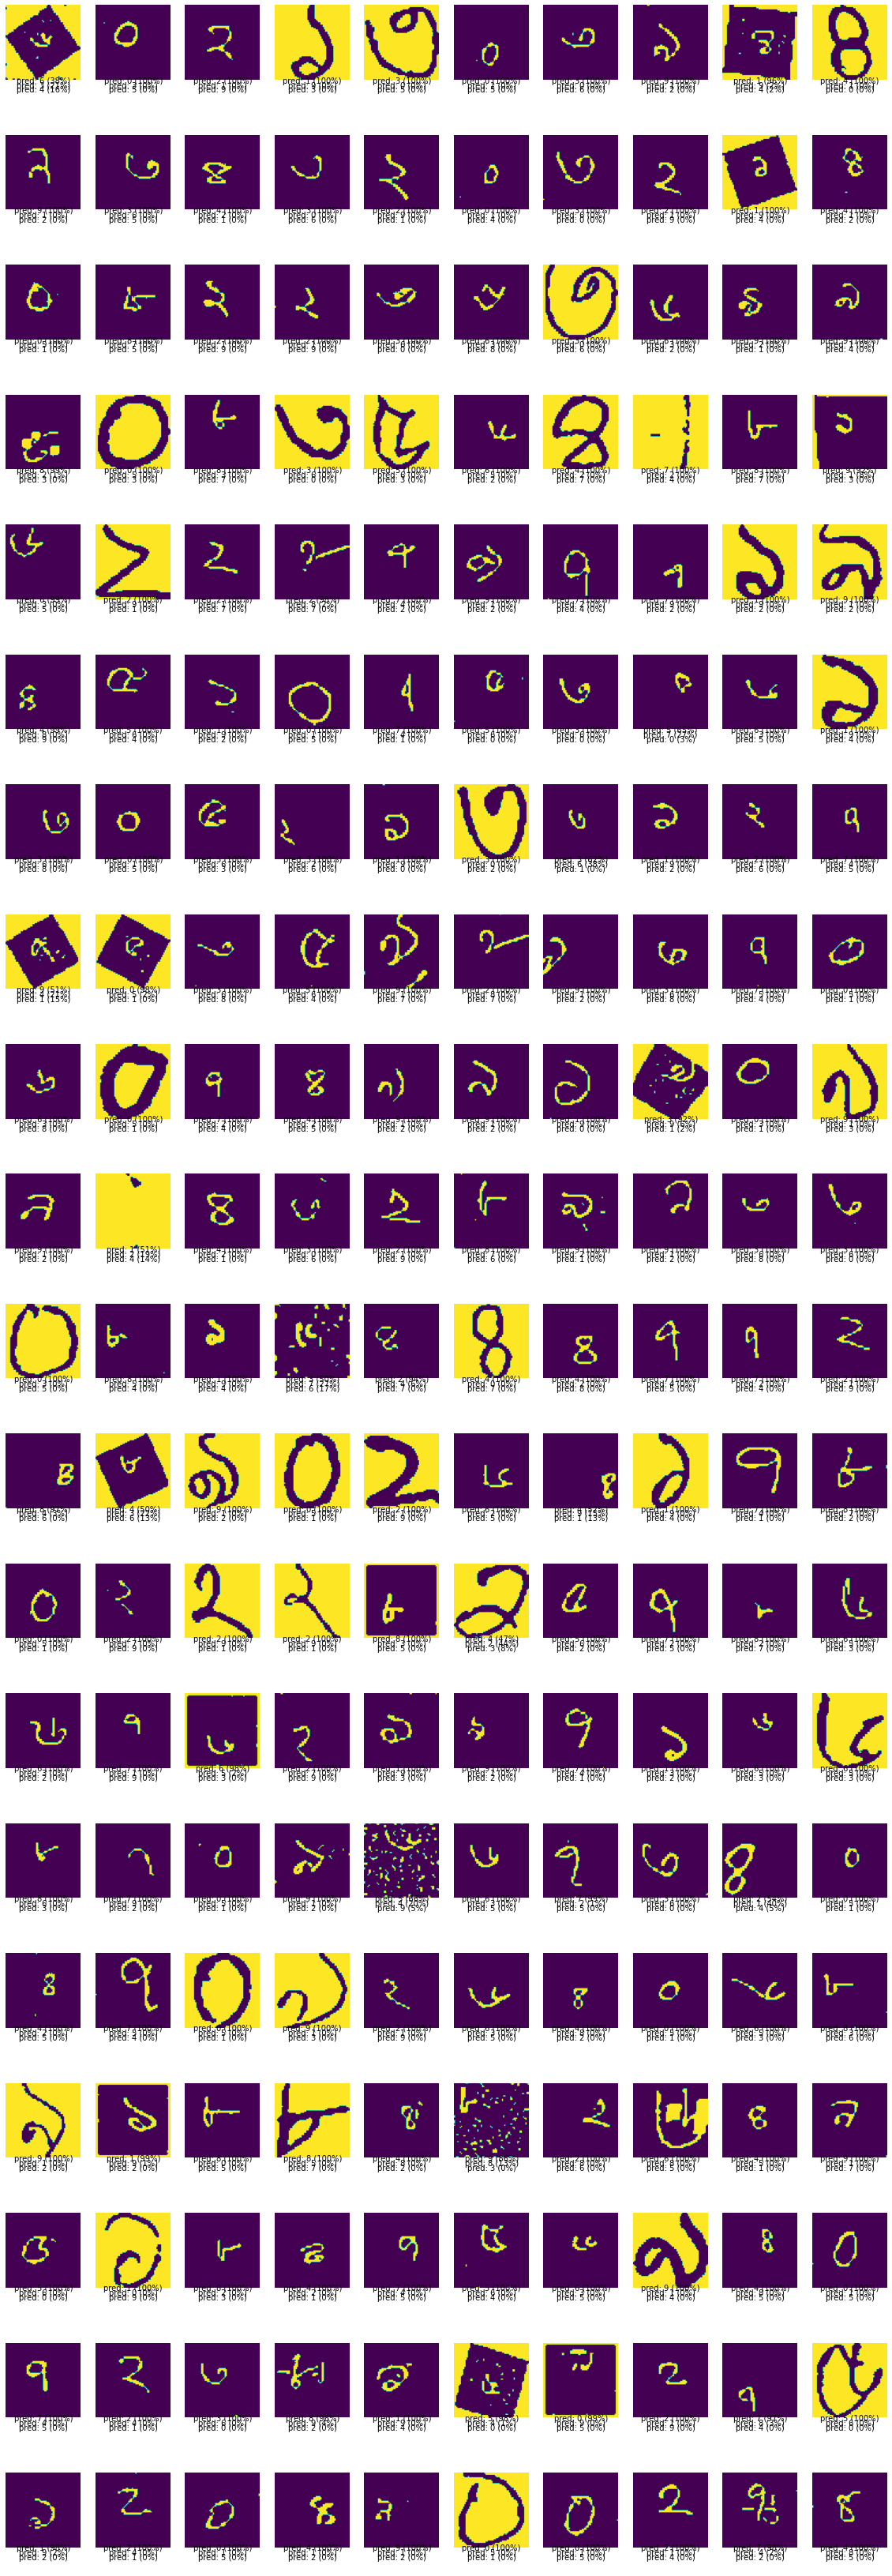

In [65]:
#imshow_group(X=X_tshow_all[ind],y=None,y_pred=predictions_prob[ind], phase='prediction')
imshow_group(X=X_test_all_big[ind],y=None,y_pred=predictions_prob[ind], phase='prediction')

In [66]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [67]:
keys=[ get_key(path) for path in paths_test_all ]

In [68]:
create_submission(predictions=labels,keys=keys,path='submission1.csv')

In [69]:
prediction = pd.read_csv('submission1.csv')
prediction.head(100)

,key,label
0,a01683.png,6
1,a01460.png,6
2,a01920.png,5
3,a00737.png,7
4,a00446.png,1
...,...,...
95,a03158.png,5
96,a00587.png,7
97,a00185.png,6
98,a01985.png,6
